In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="cifar10"
 
model_name="EfficientNetb3_stn2"
version = "b3"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=10
num_classes=-1
learning_rate=0.001
image_size=(res,res)

if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10


print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)
print("The input image size is:{}".format(image_size))

Model: EfficientNetb3_stn2 with 10 classes running on: cifar10
The input image size is:(300, 300)


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)
    





print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 300, 300])
Datasets loaded and prepared


In [3]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            nn.Conv2d(3,4,kernel_size=3,stride = 2,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,10,kernel_size=1),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(50410, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 71 * 71)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))


def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b3"
    phi, res, drop_rate = phi_values[version]
    num_examples = 4
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)
    print(x.shape)
    print(model(x).shape) # (num_examples, num_classes)

test()

#print("Efficient Net model defined")

torch.Size([4, 3, 300, 300])
torch.Size([4, 10])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [4]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

torch.Size([10, 3, 300, 300])
torch.Size([10, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 150, 150]             112
       BatchNorm2d-2          [-1, 4, 150, 150]               8
              ReLU-3          [-1, 4, 150, 150]               0
            Conv2d-4          [-1, 8, 150, 150]              40
       BatchNorm2d-5          [-1, 8, 150, 150]              16
              ReLU-6          [-1, 8, 150, 150]               0
            Conv2d-7          [-1, 8, 148, 148]             584
       BatchNorm2d-8          [-1, 8, 148, 148]              16
              ReLU-9          [-1, 8, 148, 148]               0
           Conv2d-10          [-1, 4, 148, 148]              36
      BatchNorm2d-11          [-1, 4, 148, 148]               8
             ReLU-12          [-1, 4, 148, 148]               0
           Conv2d-13          [-1, 8, 148, 148]     

     BatchNorm2d-396         [-1, 1392, 10, 10]           2,784
            SiLU-397         [-1, 1392, 10, 10]               0
        CNNBlock-398         [-1, 1392, 10, 10]               0
AdaptiveAvgPool2d-399           [-1, 1392, 1, 1]               0
          Conv2d-400             [-1, 58, 1, 1]          80,794
            SiLU-401             [-1, 58, 1, 1]               0
          Conv2d-402           [-1, 1392, 1, 1]          82,128
         Sigmoid-403           [-1, 1392, 1, 1]               0
SqueezeExcitation-404         [-1, 1392, 10, 10]               0
          Conv2d-405          [-1, 232, 10, 10]         322,944
     BatchNorm2d-406          [-1, 232, 10, 10]             464
InvertedResidualBlock-407          [-1, 232, 10, 10]               0
          Conv2d-408         [-1, 1392, 10, 10]       2,906,496
     BatchNorm2d-409         [-1, 1392, 10, 10]           2,784
            SiLU-410         [-1, 1392, 10, 10]               0
        CNNBlock-411         [-1,

In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb3_stn220211216001608
grandstore_string:
grandstore/cifar10_EfficientNetb3_stn220211216001608.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 15
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=400,
                    minepoch=300,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 40.020
Training Loss: 165715164.3474 	Validation Loss: 15967.1486

Running epoch: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 59.040
Training Loss: 123509315.5951 	Validation Loss: 11347.6299

Running epoch: 3


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 66.860
Training Loss: 94758982.1063 	Validation Loss: 9352.6648

Running epoch: 4


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 73.980
Training Loss: 77555712.9744 	Validation Loss: 7515.2723

Running epoch: 5


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 77.220
Training Loss: 64448273.7955 	Validation Loss: 6642.9624

Running epoch: 6


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 80.980
Training Loss: 54749592.5007 	Validation Loss: 5738.6178

Running epoch: 7


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 81.410
Training Loss: 47457215.4286 	Validation Loss: 5634.5494

Running epoch: 8


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.070
Training Loss: 41399193.5111 	Validation Loss: 5060.9985

Running epoch: 9


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 82.870
Training Loss: 36523283.8265 	Validation Loss: 5060.8328

Running epoch: 10


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.920
Training Loss: 32422734.4647 	Validation Loss: 4949.5335

Running epoch: 11


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.920
Training Loss: 28356870.4909 	Validation Loss: 5107.0988

Running epoch: 12


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.940
Training Loss: 25492237.7099 	Validation Loss: 4885.1006

Running epoch: 13


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.140
Training Loss: 21561289.1186 	Validation Loss: 5168.6909

Running epoch: 14


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.910
Training Loss: 19878742.6608 	Validation Loss: 5379.0701

Running epoch: 15


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.080
Training Loss: 17329241.2089 	Validation Loss: 5432.6335

Running epoch: 16


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.750
Training Loss: 15634946.7681 	Validation Loss: 5310.7191

Running epoch: 17


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.050
Training Loss: 13947128.1359 	Validation Loss: 5556.8151

Running epoch: 18


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.040
Training Loss: 12738580.1465 	Validation Loss: 5420.5172

Running epoch: 19


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.440
Training Loss: 11851494.6865 	Validation Loss: 5646.0589

Running epoch: 20


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.300
Training Loss: 10916985.1192 	Validation Loss: 5950.7972

Running epoch: 21


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.940
Training Loss: 10205797.6349 	Validation Loss: 6328.3562

Running epoch: 22


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.740
Training Loss: 9536419.9925 	Validation Loss: 6292.9131

Running epoch: 23


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.630
Training Loss: 9093820.7933 	Validation Loss: 6179.0140

Running epoch: 24


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.960
Training Loss: 8369873.8670 	Validation Loss: 6380.8780

Running epoch: 25


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.970
Training Loss: 7882803.0429 	Validation Loss: 6686.1913

Running epoch: 26


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 7600551.9626 	Validation Loss: 5845.4917

Running epoch: 27


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.190
Training Loss: 7268940.4786 	Validation Loss: 6591.0966

Running epoch: 28


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 7030427.2208 	Validation Loss: 6130.2060

Running epoch: 29


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 6580241.2657 	Validation Loss: 6117.9419

Running epoch: 30


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 6368758.8055 	Validation Loss: 6335.2384

Running epoch: 31


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.510
Training Loss: 6366607.6499 	Validation Loss: 6937.9178

Running epoch: 32


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.920
Training Loss: 5948098.2177 	Validation Loss: 7116.8810

Running epoch: 33


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 5817956.4998 	Validation Loss: 6784.5326

Running epoch: 34


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.240
Training Loss: 5816213.0713 	Validation Loss: 6612.2745

Running epoch: 35


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.210
Training Loss: 5294438.3538 	Validation Loss: 7035.9489

Running epoch: 36


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 5211367.1737 	Validation Loss: 6978.0652

Running epoch: 37


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.570
Training Loss: 5277775.9747 	Validation Loss: 7090.3023

Running epoch: 38


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.860
Training Loss: 4721694.9695 	Validation Loss: 6872.7512

Running epoch: 39


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.180
Training Loss: 4679545.7171 	Validation Loss: 7487.3744

Running epoch: 40


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.120
Training Loss: 4534307.5701 	Validation Loss: 6965.8173

Running epoch: 41


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.700
Training Loss: 4329000.5049 	Validation Loss: 7628.1842

Running epoch: 42


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 4560490.5339 	Validation Loss: 6966.5914

Running epoch: 43


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 4348145.1082 	Validation Loss: 7086.6638

Running epoch: 44


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.340
Training Loss: 4072980.8587 	Validation Loss: 7265.2310

Running epoch: 45


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.340
Training Loss: 4071150.0989 	Validation Loss: 7149.0492

Running epoch: 46


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 4259107.6047 	Validation Loss: 7129.0145

Running epoch: 47


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.660
Training Loss: 4082877.3951 	Validation Loss: 7023.7552

Running epoch: 48


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 3851332.0092 	Validation Loss: 7153.0287

Running epoch: 49


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.460
Training Loss: 3415411.8976 	Validation Loss: 7300.1573

Running epoch: 50


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.700
Training Loss: 3596033.8912 	Validation Loss: 7241.3847

Running epoch: 51


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.450
Training Loss: 3478481.2641 	Validation Loss: 7271.5541

Running epoch: 52


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.530
Training Loss: 3744189.6618 	Validation Loss: 7369.1790

Running epoch: 53


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.670
Training Loss: 3812290.4087 	Validation Loss: 7557.5431

Running epoch: 54


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.180
Training Loss: 3438121.4772 	Validation Loss: 7040.1291

Running epoch: 55


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.500
Training Loss: 3373081.9236 	Validation Loss: 8097.3745

Running epoch: 56


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.330
Training Loss: 3033827.1765 	Validation Loss: 7876.5717

Running epoch: 57


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 3328879.5144 	Validation Loss: 7829.4249

Running epoch: 58


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.600
Training Loss: 3108907.3640 	Validation Loss: 7542.7060

Running epoch: 59


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 2846498.8290 	Validation Loss: 7119.2258

Running epoch: 60


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 3169506.5348 	Validation Loss: 7560.0915

Running epoch: 61


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 3085695.0583 	Validation Loss: 7212.7855

Running epoch: 62


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.790
Training Loss: 3062706.4670 	Validation Loss: 7337.3507

Running epoch: 63


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.470
Training Loss: 3007650.8424 	Validation Loss: 7822.8349

Running epoch: 64


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 2781431.9098 	Validation Loss: 7064.0006

Running epoch: 65


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 2810833.6093 	Validation Loss: 7969.0387

Running epoch: 66


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.540
Training Loss: 2888976.9409 	Validation Loss: 7689.3456

Running epoch: 67


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.270
Training Loss: 2930720.2079 	Validation Loss: 7826.8513

Running epoch: 68


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.120
Training Loss: 2581249.9047 	Validation Loss: 7666.8259

Running epoch: 69


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.090
Training Loss: 2535928.2976 	Validation Loss: 7454.9429

Running epoch: 70


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.650
Training Loss: 2617197.9028 	Validation Loss: 7835.3908

Running epoch: 71


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 2599669.4869 	Validation Loss: 7581.1726

Running epoch: 72


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 2551437.7949 	Validation Loss: 7988.7725

Running epoch: 73


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 2579985.6835 	Validation Loss: 7214.1403

Running epoch: 74


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 2378893.1290 	Validation Loss: 7273.6538

Running epoch: 75


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 2422364.2722 	Validation Loss: 7676.4699

Running epoch: 76


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 2417229.5114 	Validation Loss: 8147.9776

Running epoch: 77


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 2657311.6951 	Validation Loss: 7889.3607

Running epoch: 78


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 2327263.2115 	Validation Loss: 7627.7063

Running epoch: 79


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 2483087.1447 	Validation Loss: 7747.4405

Running epoch: 80


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 2327121.5833 	Validation Loss: 7726.0108

Running epoch: 81


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 2320293.2802 	Validation Loss: 7560.8376

Running epoch: 82


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.280
Training Loss: 2228543.4053 	Validation Loss: 8180.5379

Running epoch: 83


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 2332333.1557 	Validation Loss: 8167.9644

Running epoch: 84


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.290
Training Loss: 2217271.9788 	Validation Loss: 8160.6985

Running epoch: 85


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 2277881.7238 	Validation Loss: 8053.5859

Running epoch: 86


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.910
Training Loss: 2277206.7937 	Validation Loss: 7941.2702

Running epoch: 87


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 2071428.7208 	Validation Loss: 7810.2220

Running epoch: 88


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.270
Training Loss: 2053056.2876 	Validation Loss: 8694.6701

Running epoch: 89


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 1924868.3308 	Validation Loss: 8063.4192

Running epoch: 90


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.160
Training Loss: 2036361.4567 	Validation Loss: 8232.2205

Running epoch: 91


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.290
Training Loss: 2067368.5997 	Validation Loss: 8530.9333

Running epoch: 92


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 1976940.9965 	Validation Loss: 7986.0490

Running epoch: 93


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 1878371.0968 	Validation Loss: 7868.1526

Running epoch: 94


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 1715358.4187 	Validation Loss: 8447.3369

Running epoch: 95


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 1984311.0741 	Validation Loss: 8297.3461

Running epoch: 96


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.160
Training Loss: 1984659.0239 	Validation Loss: 8711.0986

Running epoch: 97


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 1997871.6072 	Validation Loss: 8918.3510

Running epoch: 98


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.270
Training Loss: 1908786.4933 	Validation Loss: 8468.4017

Running epoch: 99


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.030
Training Loss: 1904124.6264 	Validation Loss: 8448.1359

Running epoch: 100


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 1883046.3809 	Validation Loss: 7968.6492

Running epoch: 101


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.840
Training Loss: 1773287.9562 	Validation Loss: 8883.8845

Running epoch: 102


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 1760042.7570 	Validation Loss: 7813.4745

Running epoch: 103


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.980
Training Loss: 1709520.2388 	Validation Loss: 8259.5109

Running epoch: 104


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 1730291.8976 	Validation Loss: 8207.6694

Running epoch: 105


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 1699760.5033 	Validation Loss: 8510.8772

Running epoch: 106


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 1957497.2817 	Validation Loss: 8164.2358

Running epoch: 107


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 1738832.0502 	Validation Loss: 8960.7377

Running epoch: 108


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 1862558.3313 	Validation Loss: 9053.4450

Running epoch: 109


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 1792167.7029 	Validation Loss: 8447.3703

Running epoch: 110


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.510
Training Loss: 1701236.8400 	Validation Loss: 8787.9000

Running epoch: 111


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.800
Training Loss: 1772960.5198 	Validation Loss: 8760.1168

Running epoch: 112


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.370
Training Loss: 1864916.0493 	Validation Loss: 8762.3985

Running epoch: 113


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 1683680.3162 	Validation Loss: 8771.9403

Running epoch: 114


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 1822000.7374 	Validation Loss: 8659.0430

Running epoch: 115


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 1611707.4666 	Validation Loss: 8136.2338

Running epoch: 116


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 1583381.2739 	Validation Loss: 8501.1509

Running epoch: 117


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 1481575.5998 	Validation Loss: 9554.2403

Running epoch: 118


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 1955211.9438 	Validation Loss: 8508.2112

Running epoch: 119


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 1529904.2750 	Validation Loss: 8290.8249

Running epoch: 120


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.990
Training Loss: 1683834.9566 	Validation Loss: 8720.1933

Running epoch: 121


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.900
Training Loss: 1275985.0236 	Validation Loss: 9121.0573

Running epoch: 122


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 1854606.7334 	Validation Loss: 9015.8156

Running epoch: 123


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 1821207.9666 	Validation Loss: 8456.1153

Running epoch: 124


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 1443258.2370 	Validation Loss: 8415.7427

Running epoch: 125


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 1540416.1625 	Validation Loss: 8782.9686

Running epoch: 126


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 1414509.0878 	Validation Loss: 8893.0901

Running epoch: 127


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.190
Training Loss: 1380930.0524 	Validation Loss: 9119.6835

Running epoch: 128


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.830
Training Loss: 1556146.0264 	Validation Loss: 8556.8614

Running epoch: 129


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.940
Training Loss: 1461500.4851 	Validation Loss: 10040.1465

Running epoch: 130


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.780
Training Loss: 1669729.7276 	Validation Loss: 8682.2401

Running epoch: 131


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 1303620.8606 	Validation Loss: 9304.4179

Running epoch: 132


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 1791824.0877 	Validation Loss: 8856.6301

Running epoch: 133


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 1356771.2470 	Validation Loss: 9047.6701

Running epoch: 134


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.270
Training Loss: 1568014.2660 	Validation Loss: 8577.5847

Running epoch: 135


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 1361128.9795 	Validation Loss: 9116.5366

Running epoch: 136


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 1526788.0020 	Validation Loss: 8825.3393

Running epoch: 137


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.980
Training Loss: 1312471.2425 	Validation Loss: 9101.3843

Running epoch: 138


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 1596874.2734 	Validation Loss: 8719.5320

Running epoch: 139


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.120
Training Loss: 1474741.0464 	Validation Loss: 8807.9993

Running epoch: 140


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.680
Training Loss: 1352831.2863 	Validation Loss: 8879.0108

Running epoch: 141


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 1331756.8916 	Validation Loss: 9353.3867

Running epoch: 142


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.170
Training Loss: 1673794.7741 	Validation Loss: 8286.1859

Running epoch: 143


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 1412777.2486 	Validation Loss: 8953.3186

Running epoch: 144


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 1317457.1751 	Validation Loss: 8676.7057

Running epoch: 145


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 1296346.0642 	Validation Loss: 8954.9929

Running epoch: 146


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.780
Training Loss: 1459663.5632 	Validation Loss: 8631.7623

Running epoch: 147


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 1084517.8695 	Validation Loss: 8741.5821

Running epoch: 148


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 1380386.9367 	Validation Loss: 8860.6739

Running epoch: 149


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 1333774.0007 	Validation Loss: 8670.2668

Running epoch: 150


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.280
Training Loss: 1316763.1605 	Validation Loss: 9742.1909

Running epoch: 151


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 1372677.2413 	Validation Loss: 9562.6262

Running epoch: 152


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.370
Training Loss: 1471703.8249 	Validation Loss: 9981.4410

Running epoch: 153


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 1301572.9617 	Validation Loss: 8388.6775

Running epoch: 154


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 1141544.1656 	Validation Loss: 9047.0170

Running epoch: 155


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.190
Training Loss: 1401392.0809 	Validation Loss: 9394.8616

Running epoch: 156


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 1263170.0305 	Validation Loss: 9270.7012

Running epoch: 157


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 1290947.5500 	Validation Loss: 8844.6405

Running epoch: 158


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 1243866.7947 	Validation Loss: 9000.9909

Running epoch: 159


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.120
Training Loss: 1083482.7555 	Validation Loss: 8771.9755

Running epoch: 160


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 1483643.8731 	Validation Loss: 8675.9135

Running epoch: 161


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 1294917.7026 	Validation Loss: 8804.4179

Running epoch: 162


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.370
Training Loss: 1172967.4302 	Validation Loss: 8579.6574

Running epoch: 163


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 1288949.0309 	Validation Loss: 9049.1197

Running epoch: 164


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 1208589.3496 	Validation Loss: 9321.8385

Running epoch: 165


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 1066914.7975 	Validation Loss: 9597.2774

Running epoch: 166


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 1249444.6320 	Validation Loss: 8806.7309

Running epoch: 167


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.350
Training Loss: 1090431.9121 	Validation Loss: 10234.2590

Running epoch: 168


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 1184159.1102 	Validation Loss: 8883.1772

Running epoch: 169


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.960
Training Loss: 1241783.1767 	Validation Loss: 9187.3986

Running epoch: 170


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.160
Training Loss: 1055965.2996 	Validation Loss: 9116.2620

Running epoch: 171


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.220
Training Loss: 1156639.1937 	Validation Loss: 9603.4417

Running epoch: 172


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 1362649.8762 	Validation Loss: 8984.2849

Running epoch: 173


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 1169545.5247 	Validation Loss: 8840.2085

Running epoch: 174


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 1188634.0025 	Validation Loss: 9424.1749

Running epoch: 175


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.270
Training Loss: 1234631.1426 	Validation Loss: 8467.4772

Running epoch: 176


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 1188259.9883 	Validation Loss: 8343.3865

Running epoch: 177


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.100
Training Loss: 1198393.0163 	Validation Loss: 8792.6234

Running epoch: 178


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 1095773.3289 	Validation Loss: 9554.0414

Running epoch: 179


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.790
Training Loss: 1235024.6787 	Validation Loss: 9278.9761

Running epoch: 180


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.370
Training Loss: 1034505.6949 	Validation Loss: 9293.7422

Running epoch: 181


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 1038738.1428 	Validation Loss: 9471.2648

Running epoch: 182


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.930
Training Loss: 979906.6659 	Validation Loss: 9360.8223

Running epoch: 183


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 994032.7897 	Validation Loss: 9319.6047

Running epoch: 184


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 1118415.0784 	Validation Loss: 9933.0619

Running epoch: 185


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 1063158.3461 	Validation Loss: 9674.6755

Running epoch: 186


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 1095599.7077 	Validation Loss: 9570.1850

Running epoch: 187


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 933931.4663 	Validation Loss: 9114.3151

Running epoch: 188


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 904311.3393 	Validation Loss: 9685.0363

Running epoch: 189


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 1184242.8057 	Validation Loss: 8983.5847

Running epoch: 190


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 1168633.5311 	Validation Loss: 9501.6143

Running epoch: 191


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 1115088.3148 	Validation Loss: 9038.0119

Running epoch: 192


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 943811.5458 	Validation Loss: 9447.6635

Running epoch: 193


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 1176863.6382 	Validation Loss: 9867.3148

Running epoch: 194


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.680
Training Loss: 1034403.9140 	Validation Loss: 10026.7899

Running epoch: 195


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 1077457.9450 	Validation Loss: 9579.3418

Running epoch: 196


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 1003664.1116 	Validation Loss: 9401.4557

Running epoch: 197


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 863387.8408 	Validation Loss: 9780.7328

Running epoch: 198


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 989759.4055 	Validation Loss: 9747.1763

Running epoch: 199


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 1361775.0534 	Validation Loss: 9195.4799

Running epoch: 200


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 890499.8959 	Validation Loss: 9772.4045

Running epoch: 201


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 1151437.4970 	Validation Loss: 10005.6317

Running epoch: 202


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 1094926.0630 	Validation Loss: 10100.6667

Running epoch: 203


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 1048241.0690 	Validation Loss: 9957.7409

Running epoch: 204


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.440
Training Loss: 917094.2778 	Validation Loss: 10045.0729

Running epoch: 205


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.780
Training Loss: 1076334.9797 	Validation Loss: 9522.5098

Running epoch: 206


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 1230260.0436 	Validation Loss: 9160.6585

Running epoch: 207


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 1077974.3501 	Validation Loss: 9239.5807

Running epoch: 208


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 852345.9610 	Validation Loss: 9448.3381

Running epoch: 209


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 1110290.8097 	Validation Loss: 9803.5126

Running epoch: 210


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 960448.3173 	Validation Loss: 9177.3721

Running epoch: 211


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 1103816.1299 	Validation Loss: 9141.3324

Running epoch: 212


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 1055039.5516 	Validation Loss: 9133.7640

Running epoch: 213


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.590
Training Loss: 986645.4412 	Validation Loss: 10346.9027

Running epoch: 214


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 727748.5960 	Validation Loss: 9779.4593

Running epoch: 215


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.610
Training Loss: 1141410.6843 	Validation Loss: 9243.0548

Running epoch: 216


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.290
Training Loss: 928840.4939 	Validation Loss: 9976.8114

Running epoch: 217


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 1114805.2159 	Validation Loss: 9403.0152

Running epoch: 218


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 1041437.4020 	Validation Loss: 10084.6633

Running epoch: 219


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.100
Training Loss: 1054117.8044 	Validation Loss: 10569.6089

Running epoch: 220


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 1013541.8860 	Validation Loss: 9034.3251

Running epoch: 221


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 790213.6047 	Validation Loss: 9473.6607

Running epoch: 222


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 909600.1850 	Validation Loss: 10298.6562

Running epoch: 223


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 1069612.1280 	Validation Loss: 9174.3236

Running epoch: 224


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 992657.5157 	Validation Loss: 9724.5427

Running epoch: 225


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 854609.0723 	Validation Loss: 9656.6562

Running epoch: 226


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.160
Training Loss: 914169.9866 	Validation Loss: 8873.3488

Running epoch: 227


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 881947.2697 	Validation Loss: 9495.1873

Running epoch: 228


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 1072190.7799 	Validation Loss: 8997.1874

Running epoch: 229


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 841417.2306 	Validation Loss: 9947.7952

Running epoch: 230


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.790
Training Loss: 889064.4665 	Validation Loss: 9247.7955

Running epoch: 231


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.470
Training Loss: 877699.1389 	Validation Loss: 10175.7253

Running epoch: 232


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 856940.7753 	Validation Loss: 10776.1333

Running epoch: 233


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 1062758.5030 	Validation Loss: 9157.8096

Running epoch: 234


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.420
Training Loss: 885536.1990 	Validation Loss: 9478.0564

Running epoch: 235


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 821788.7578 	Validation Loss: 10209.5227

Running epoch: 236


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 1128698.7112 	Validation Loss: 10412.0881

Running epoch: 237


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 778268.4233 	Validation Loss: 10530.4480

Running epoch: 238


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 1084892.6492 	Validation Loss: 9549.3196

Running epoch: 239


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 892264.4374 	Validation Loss: 10084.4314

Running epoch: 240


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 856385.7305 	Validation Loss: 10318.2428

Running epoch: 241


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.810
Training Loss: 1048698.3938 	Validation Loss: 9794.0882

Running epoch: 242


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.710
Training Loss: 806559.7432 	Validation Loss: 10302.8075

Running epoch: 243


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 795365.4451 	Validation Loss: 10030.4714

Running epoch: 244


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.150
Training Loss: 703499.8412 	Validation Loss: 10528.2731

Running epoch: 245


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.230
Training Loss: 1082063.2731 	Validation Loss: 10149.5258

Running epoch: 246


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 815502.9361 	Validation Loss: 11063.7117

Running epoch: 247


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.950
Training Loss: 965514.9177 	Validation Loss: 10280.7985

Running epoch: 248


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.740
Training Loss: 832547.8044 	Validation Loss: 10612.7901

Running epoch: 249


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.150
Training Loss: 974687.8747 	Validation Loss: 10098.3805

Running epoch: 250


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 811354.6126 	Validation Loss: 10360.1945

Running epoch: 251


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.130
Training Loss: 1020605.4179 	Validation Loss: 9747.6295

Running epoch: 252


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 810785.6252 	Validation Loss: 10351.6495

Running epoch: 253


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.250
Training Loss: 982005.4189 	Validation Loss: 9796.5181

Running epoch: 254


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 684525.2821 	Validation Loss: 10083.1287

Running epoch: 255


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.140
Training Loss: 1011383.3334 	Validation Loss: 9763.2488

Running epoch: 256


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.470
Training Loss: 660896.5459 	Validation Loss: 10065.7359

Running epoch: 257


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 990449.6025 	Validation Loss: 10244.8682

Running epoch: 258


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.970
Training Loss: 867371.9412 	Validation Loss: 9903.7233

Running epoch: 259


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 878371.2422 	Validation Loss: 10578.2570

Running epoch: 260


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 928363.0522 	Validation Loss: 11016.9828

Running epoch: 261


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 899277.6550 	Validation Loss: 9926.5339

Running epoch: 262


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 712875.6846 	Validation Loss: 10859.1258

Running epoch: 263


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.900
Training Loss: 606956.3718 	Validation Loss: 10030.2463

Running epoch: 264


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 729541.3328 	Validation Loss: 10521.2203

Running epoch: 265


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.060
Training Loss: 799624.6961 	Validation Loss: 9701.4942

Running epoch: 266


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.790
Training Loss: 858675.8336 	Validation Loss: 10014.8126

Running epoch: 267


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.810
Training Loss: 1011558.8758 	Validation Loss: 10379.3731

Running epoch: 268


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 914135.7409 	Validation Loss: 10869.1638

Running epoch: 269


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.870
Training Loss: 890278.6495 	Validation Loss: 10568.7138

Running epoch: 270


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.860
Training Loss: 1043487.1432 	Validation Loss: 11435.8951

Running epoch: 271


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 721081.0050 	Validation Loss: 10585.7713

Running epoch: 272


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 780442.1991 	Validation Loss: 10671.3501

Running epoch: 273


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 947355.4600 	Validation Loss: 10651.5462

Running epoch: 274


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 971739.0843 	Validation Loss: 10243.4378

Running epoch: 275


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 757324.8945 	Validation Loss: 10718.8533

Running epoch: 276


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 945935.8018 	Validation Loss: 10630.0411

Running epoch: 277


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 833341.5569 	Validation Loss: 10058.1630

Running epoch: 278


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 836520.7140 	Validation Loss: 10878.3151

Running epoch: 279


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 717083.6135 	Validation Loss: 10899.5406

Running epoch: 280


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 881450.7973 	Validation Loss: 10709.0342

Running epoch: 281


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 777659.5702 	Validation Loss: 11798.9230

Running epoch: 282


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 910856.9000 	Validation Loss: 10883.5932

Running epoch: 283


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 968922.6355 	Validation Loss: 11194.0320

Running epoch: 284


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.260
Training Loss: 1003881.4439 	Validation Loss: 9308.3297

Running epoch: 285


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 483456.2263 	Validation Loss: 11141.2128

Running epoch: 286


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 1268494.5403 	Validation Loss: 10530.2746

Running epoch: 287


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.040
Training Loss: 868558.1551 	Validation Loss: 9595.9663

Running epoch: 288


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 1050093.6283 	Validation Loss: 10711.4645

Running epoch: 289


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.170
Training Loss: 803017.0904 	Validation Loss: 9755.9853

Running epoch: 290


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 808657.0100 	Validation Loss: 9805.3706

Running epoch: 291


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 707672.4526 	Validation Loss: 10301.2026

Running epoch: 292


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 750962.4576 	Validation Loss: 10548.0797

Running epoch: 293


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.280
Training Loss: 722191.2956 	Validation Loss: 9750.9245

Running epoch: 294


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.060
Training Loss: 835076.3341 	Validation Loss: 10169.2227

Running epoch: 295


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 730606.2074 	Validation Loss: 10803.3936

Running epoch: 296


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.220
Training Loss: 709906.3381 	Validation Loss: 10582.8931

Running epoch: 297


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.220
Training Loss: 885007.4112 	Validation Loss: 10437.9110

Running epoch: 298


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 735696.2638 	Validation Loss: 11512.0246

Running epoch: 299


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 924519.7865 	Validation Loss: 10083.1483

Running epoch: 300


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.120
Training Loss: 698629.7370 	Validation Loss: 10578.4595

Running epoch: 301


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.060
Training Loss: 655447.9601 	Validation Loss: 10273.9580

Running epoch: 302


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.360
Training Loss: 700405.0078 	Validation Loss: 10524.1027

Running epoch: 303


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.810
Training Loss: 896262.1602 	Validation Loss: 10345.9708

Running epoch: 304


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.320
Training Loss: 786690.5916 	Validation Loss: 10632.2591

Running epoch: 305


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.120
Training Loss: 845789.2758 	Validation Loss: 10028.5799

Running epoch: 306


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 629443.2524 	Validation Loss: 10703.0045

Running epoch: 307


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.300
Training Loss: 851073.8075 	Validation Loss: 10576.8286

Running epoch: 308


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.280
Training Loss: 665916.5557 	Validation Loss: 10289.7096

Running epoch: 309


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.240
Training Loss: 1037107.0427 	Validation Loss: 9330.2557

Running epoch: 310


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 805940.8011 	Validation Loss: 10748.8940

Running epoch: 311


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.310
Training Loss: 674133.9784 	Validation Loss: 11669.8688

Running epoch: 312


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.150
Training Loss: 660720.5263 	Validation Loss: 11255.5961

Running epoch: 313


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.100
Training Loss: 810618.2118 	Validation Loss: 10135.0964

Running epoch: 314


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 650077.7066 	Validation Loss: 10116.3297

Running epoch: 315


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.430
Training Loss: 712656.3798 	Validation Loss: 10525.8746

Running epoch: 316


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 867371.6741 	Validation Loss: 10551.4885

Running epoch: 317


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.910
Training Loss: 770841.0935 	Validation Loss: 10457.0780

Running epoch: 318


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.610
Training Loss: 602361.3483 	Validation Loss: 10370.9344

Running epoch: 319


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 615813.9099 	Validation Loss: 10537.6232

Running epoch: 320


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.980
Training Loss: 732867.8438 	Validation Loss: 11197.3358

Running epoch: 321


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.420
Training Loss: 844857.7086 	Validation Loss: 10704.3121

Running epoch: 322


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.240
Training Loss: 782256.8511 	Validation Loss: 10088.0396

Running epoch: 323


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.060
Training Loss: 679845.6141 	Validation Loss: 10220.4835

Running epoch: 324


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.850
Training Loss: 686247.4551 	Validation Loss: 10493.2291

Running epoch: 325


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.960
Training Loss: 781251.8301 	Validation Loss: 10243.1452

Running epoch: 326


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 577463.7647 	Validation Loss: 10542.2089

Running epoch: 327


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.790
Training Loss: 746943.4676 	Validation Loss: 11314.6176

Running epoch: 328


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 540820.6255 	Validation Loss: 11422.1390

Running epoch: 329


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 693177.5297 	Validation Loss: 11080.4817

Running epoch: 330


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.140
Training Loss: 818405.3335 	Validation Loss: 10991.2206

Running epoch: 331


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.390
Training Loss: 762834.8160 	Validation Loss: 10243.0192

Running epoch: 332


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 808931.2426 	Validation Loss: 10534.2287

Running epoch: 333


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 963161.8502 	Validation Loss: 9813.6670

Running epoch: 334


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.270
Training Loss: 619691.7779 	Validation Loss: 10336.7572

Running epoch: 335


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 746413.5834 	Validation Loss: 10435.6556

Running epoch: 336


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 746489.7208 	Validation Loss: 11050.6149

Running epoch: 337


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.950
Training Loss: 572924.5392 	Validation Loss: 10517.8952

Running epoch: 338


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 713038.1488 	Validation Loss: 11424.0462

Running epoch: 339


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.800
Training Loss: 607417.5823 	Validation Loss: 10624.1553

Running epoch: 340


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.290
Training Loss: 850584.8680 	Validation Loss: 10384.3521

Running epoch: 341


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 653693.0553 	Validation Loss: 10489.6900

Running epoch: 342


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.320
Training Loss: 640953.0037 	Validation Loss: 10436.3008

Running epoch: 343


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.830
Training Loss: 841852.7037 	Validation Loss: 10592.7206

Running epoch: 344


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.370
Training Loss: 678587.0458 	Validation Loss: 10196.4252

Running epoch: 345


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 762438.1248 	Validation Loss: 11064.9266

Running epoch: 346


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.470
Training Loss: 796139.6163 	Validation Loss: 10187.4371

Running epoch: 347


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 581265.6757 	Validation Loss: 12043.9201

Running epoch: 348


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 450029.9630 	Validation Loss: 10836.6469

Running epoch: 349


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.040
Training Loss: 857309.9618 	Validation Loss: 10872.4301

Running epoch: 350


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.380
Training Loss: 719001.6898 	Validation Loss: 10492.6235

Running epoch: 351


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 558865.5821 	Validation Loss: 11299.0084

Running epoch: 352


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 652757.4205 	Validation Loss: 11182.5915

Running epoch: 353


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 554098.0326 	Validation Loss: 11401.5166

Running epoch: 354


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.980
Training Loss: 720753.3310 	Validation Loss: 11244.5516

Running epoch: 355


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.350
Training Loss: 888736.3392 	Validation Loss: 10365.9729

Running epoch: 356


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 1221797.1615 	Validation Loss: 10099.3042

Running epoch: 357


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.040
Training Loss: 609627.4612 	Validation Loss: 10506.1989

Running epoch: 358


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.910
Training Loss: 774535.7688 	Validation Loss: 10950.6672

Running epoch: 359


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 523685.8819 	Validation Loss: 11116.7500

Running epoch: 360


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 733233.3645 	Validation Loss: 10262.2141

Running epoch: 361


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 728194.2649 	Validation Loss: 10302.0399

Running epoch: 362


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 640133.4716 	Validation Loss: 10564.1655

Running epoch: 363


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.240
Training Loss: 624749.6487 	Validation Loss: 10626.7447

Running epoch: 364


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 668915.0710 	Validation Loss: 12000.6027

Running epoch: 365


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 600961.8024 	Validation Loss: 10742.3197

Running epoch: 366


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 634088.3814 	Validation Loss: 10683.0613

Running epoch: 367


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 705273.0440 	Validation Loss: 11266.5048

Running epoch: 368


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.430
Training Loss: 1290669.8327 	Validation Loss: 10181.3568

Running epoch: 369


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.790
Training Loss: 551111.6152 	Validation Loss: 10980.8499

Running epoch: 370


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 601095.4006 	Validation Loss: 12630.7806

Running epoch: 371


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 696482.4148 	Validation Loss: 11430.7307

Running epoch: 372


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 603026.2463 	Validation Loss: 11286.4191

Running epoch: 373


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 652747.4339 	Validation Loss: 10377.8798

Running epoch: 374


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.340
Training Loss: 776083.9350 	Validation Loss: 10087.1545

Running epoch: 375


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.640
Training Loss: 1344723.2387 	Validation Loss: 9602.7401

Running epoch: 376


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 534582.1688 	Validation Loss: 11325.6801

Running epoch: 377


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 809516.3415 	Validation Loss: 10922.5764

Running epoch: 378


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 607596.4313 	Validation Loss: 11232.9973

Running epoch: 379


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 684551.1179 	Validation Loss: 10789.4412

Running epoch: 380


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.580
Training Loss: 586127.0010 	Validation Loss: 10531.5319

Running epoch: 381


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.690
Training Loss: 625977.5899 	Validation Loss: 10912.9913

Running epoch: 382


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 565999.1440 	Validation Loss: 11004.0167

Running epoch: 383


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 623674.5591 	Validation Loss: 11141.7366

Running epoch: 384


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.800
Training Loss: 605999.4197 	Validation Loss: 10852.9669

Running epoch: 385


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.780
Training Loss: 755239.0015 	Validation Loss: 10127.1340

early stop occured!!


  0%|          | 0/1000 [00:00<?, ?it/s]

Total Run 385 epoch(s)
Accuracy MIN: 40.02 / MAX: 87.64

Top 15 performing epochs:
#1 epoch 375	||train_acc 87.64%	||test 87.22%
#2 epoch 256	||train_acc 87.47%	||test 86.67%
#3 epoch 346	||train_acc 87.47%	||test 86.42%
#4 epoch 368	||train_acc 87.43%	||test 87.07%
#5 epoch 331	||train_acc 87.39%	||test 87.18%
#6 epoch 350	||train_acc 87.38%	||test 86.71%
#7 epoch 344	||train_acc 87.37%	||test 86.95%
#8 epoch 302	||train_acc 87.36%	||test 87.04%
#9 epoch 355	||train_acc 87.35%	||test 86.89%
#10 epoch 374	||train_acc 87.34%	||test 87.13%
#11 epoch 342	||train_acc 87.32%	||test 86.56%
#12 epoch 307	||train_acc 87.3%	||test 86.62%
#13 epoch 340	||train_acc 87.29%	||test 87.05%
#14 epoch 293	||train_acc 87.28%	||test 86.98%
#15 epoch 308	||train_acc 87.28%	||test 86.8%

Last epoch:
epoch 385	||train_acc 86.78%	||test 86.42%

The model has parameters: 42265546


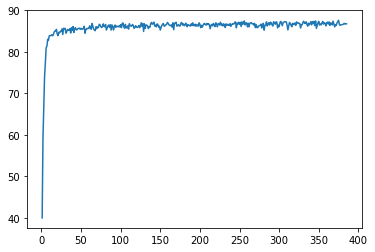

In [9]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/cifar10_EfficientNetb3_stn220211216001608.pkl
